Install Packages

In [ ]:
!pip install numpy pandas matplotlib seaborn scikit-learn yfinance

Imports!!

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso  # Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from datetime import datetime, timedelta

Data Collection & Feature Engineering

In [ ]:
def fetch_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Download data
end_date = datetime.now().strftime('%Y-%m-%d')
df = fetch_stock_data('AAPL', '2015-01-01', end_date)
df = df[['Close']].rename(columns={'Close': 'price'})

# Feature engineering function
def create_features(data, target_days=5, window_sizes=[5, 10, 20, 50, 100]):
    df = data.copy()

    # Price transformations
    df['log_price'] = np.log(df['price'])
    df['price_change'] = df['price'].pct_change()

    # Technical indicators
    for window in window_sizes:
        # Moving averages
        df[f'ma_{window}'] = df['price'].rolling(window=window).mean()
        df[f'ema_{window}'] = df['price'].ewm(span=window, adjust=False).mean()

        # Volatility
        df[f'volatility_{window}'] = df['price'].pct_change().rolling(window).std() # ish... I don't know.

        # Min/max
        df[f'min_{window}'] = df['price'].rolling(window=window).min()
        df[f'max_{window}'] = df['price'].rolling(window=window).max()

        # Momentum
        df[f'momentum_{window}'] = df['price'] / df['price'].shift(window) - 1

    # Volume indicators (if available)
    if 'Volume' in data.columns:
        for window in [5, 20]:
            df[f'volume_ma_{window}'] = data['Volume'].rolling(window=window).mean()

    # Date features
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter

    # Target variable (future price)
    df['target'] = df['price'].shift(-target_days)

    # Drop missing values
    df = df.dropna()

    return df

# Create features with 5-day ahead prediction
featured_df = create_features(df, target_days=5)

/tmp/ipython-input-19-2944971167.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Train-Test Split (Time-Based)!

In [ ]:
# Split into features and target
X = featured_df.drop(['price', 'target', 'log_price'], axis=1)
y = featured_df['target']

# Time-based split (last 20% for testing)
split_point = int(0.8 * len(X))
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Model Training with LASSO Regression

In [ ]:
# Initialize and tune LASSO regression
lasso = Lasso(max_iter=10000)  # Increased max_iter for convergence
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 100, 500, 1000]}

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Grid search
grid_search = GridSearchCV(lasso, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best model
best_lasso = grid_search.best_estimator_
print(f"Best alpha: {grid_search.best_params_['alpha']}")
print(f"Number of features used: {np.sum(best_lasso.coef_ != 0)}")

Best alpha: 0.01
Number of features used: 17


Model Evaluation

In [ ]:
# Predictions
y_train_pred = best_lasso.predict(X_train_scaled)
y_test_pred = best_lasso.predict(X_test_scaled)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))       # looking for the joy!
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

Train RMSE: 3.7364
Test RMSE: 8.2444
Train R²: 0.9948
Test R²: 0.8803


Future Price Prediction Function

In [ ]:
def predict_future_prices(model, scaler, last_known_data, feature_columns, days_to_predict=30):
    """
    Recursively predicts future stock prices

    Parameters:
    - model: Trained regression model (LASSO)
    - scaler: Fitted StandardScaler
    - last_known_data: Most recent row of features (as a Series)
    - feature_columns: List of feature column names (as strings)
    - days_to_predict: Number of days to predict ahead
    - stuck in the club spending money with all the losers

    Returns:
    - DataFrame with dates and predicted prices
    """

    predictions = []
    current_data = last_known_data.copy()

    for day in range(days_to_predict):
        # Prepare features for prediction - ensure we're using a list of column names
        features = current_data[list(feature_columns)].values.reshape(1, -1)  # Explicitly convert to list
        features_scaled = scaler.transform(features)

        # Make prediction
        pred_price = model.predict(features_scaled)[0]
        predictions.append(pred_price)

        # Update features for next prediction
        new_row = current_data.copy()

        # Update price-related features
        new_row['price'] = pred_price
        if 'log_price' in current_data.index:  # Check if exists before updating
            new_row['log_price'] = np.log(pred_price)
        if 'price_change' in current_data.index:
            new_row['price_change'] = (pred_price - current_data['price']) / current_data['price']

        # Update moving averages and other rolling features
        for col in feature_columns:
            if str(col).startswith('ma_') or str(col).startswith('ema_'):  # Ensure col is string
                new_row[col] = current_data[col] * 0.9 + pred_price * 0.1  # Approximate

        current_data = new_row

    # Create date index for future predictions
    last_date = last_known_data.name
    future_dates = [last_date + timedelta(days=i) for i in range(1, days_to_predict+1)]

    return pd.DataFrame({'date': future_dates, 'predicted_price': predictions}).set_index('date')

# Get the most recent data point properly
last_known = featured_df.iloc[-1]  # This should be a pandas Series

# Ensure feature_columns is a list of strings
feature_columns = X.columns.tolist()  # Convert to list if it's not already

# Predict 30 days into the future with the fixed function
future_predictions = predict_future_prices(best_lasso, scaler, last_known, feature_columns, 30)

# Display the predictions
print(future_predictions.head())

            predicted_price
date                       
2025-07-08       213.048034
2025-07-09       213.832545
2025-07-10       213.557747
2025-07-11       213.434478
2025-07-12       213.452045


In [ ]:
# Verification checks
print(f"Type of last_known: {type(last_known)}")  # Should be pandas Series
print(f"Type of feature_columns: {type(feature_columns)}")  # Should be list
print(f"First few feature columns: {feature_columns[:5]}")  # Should show strings

# Ensure all feature columns exist in the last_known data
missing_cols = [col for col in feature_columns if col not in last_known.index]
if missing_cols:
    print(f"Warning: Missing columns in last_known data: {missing_cols}")
else:
    print("All feature columns present in last_known data")

Type of last_known: <class 'pandas.core.series.Series'>
Type of feature_columns: <class 'list'>
First few feature columns: [('price_change', ''), ('ma_5', ''), ('ema_5', ''), ('volatility_5', ''), ('min_5', '')]
All feature columns present in last_known data


Visualization of Predictions

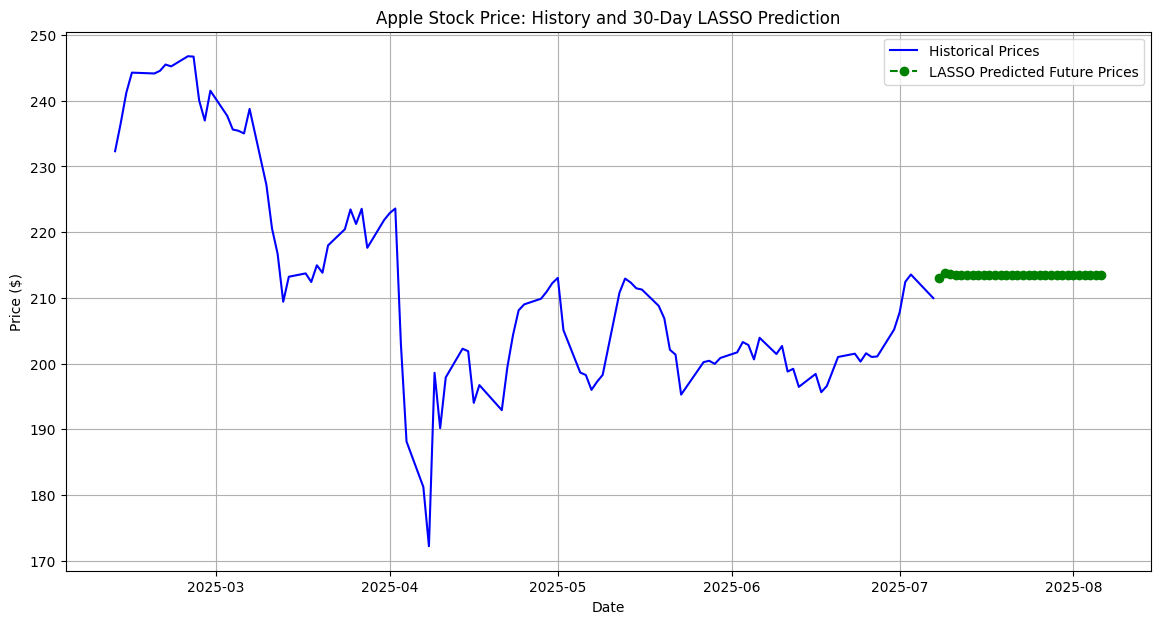

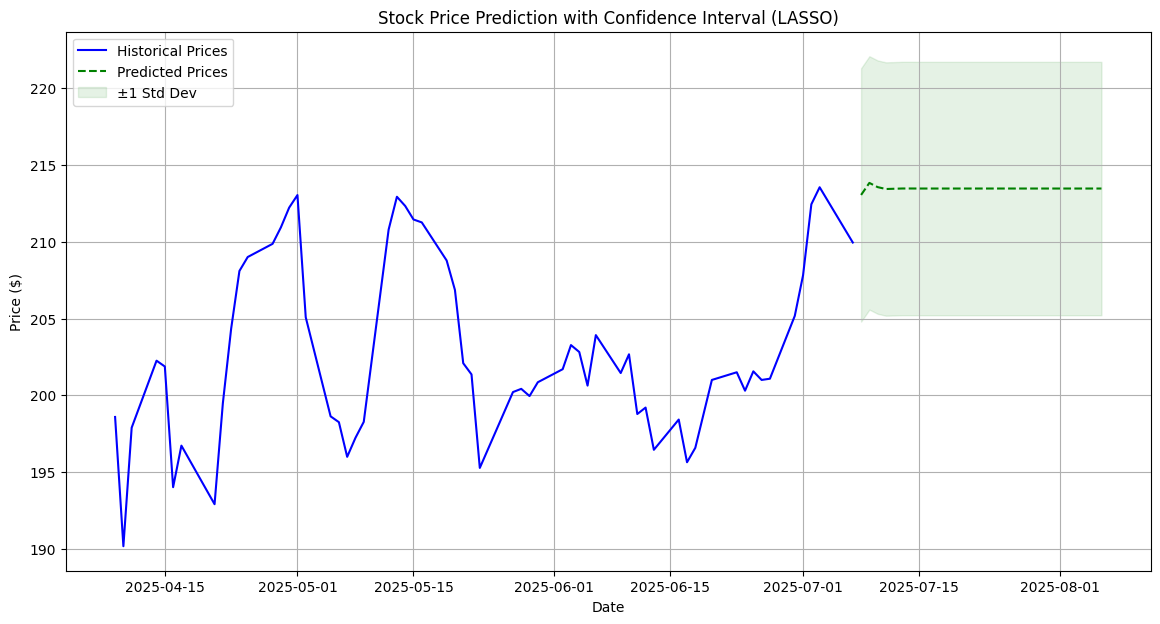

In [ ]:
# Plot historical and predicted prices
plt.figure(figsize=(14, 7))
plt.plot(featured_df['price'][-100:], label='Historical Prices', color='blue')
plt.plot(future_predictions['predicted_price'], label='LASSO Predicted Future Prices',
         color='green', linestyle='--', marker='o')
plt.title('Apple Stock Price: History and 30-Day LASSO Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

# Plot with confidence interval
plt.figure(figsize=(14, 7))
plt.plot(featured_df['price'][-60:], label='Historical Prices', color='blue')

# Calculate standard deviation of residuals for confidence interval
residuals = y_test - y_test_pred
std_dev = residuals.std()

# Plot predictions with ±1 standard deviation
plt.plot(future_predictions['predicted_price'], label='Predicted Prices',
         color='green', linestyle='--')
plt.fill_between(future_predictions.index,
                 future_predictions['predicted_price'] - std_dev,
                 future_predictions['predicted_price'] + std_dev,
                 color='green', alpha=0.1, label='±1 Std Dev')

plt.title('Stock Price Prediction with Confidence Interval (LASSO)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

Feature Importance Analysis - I think I got this part wrong?

Number of features used: 17 out of 34


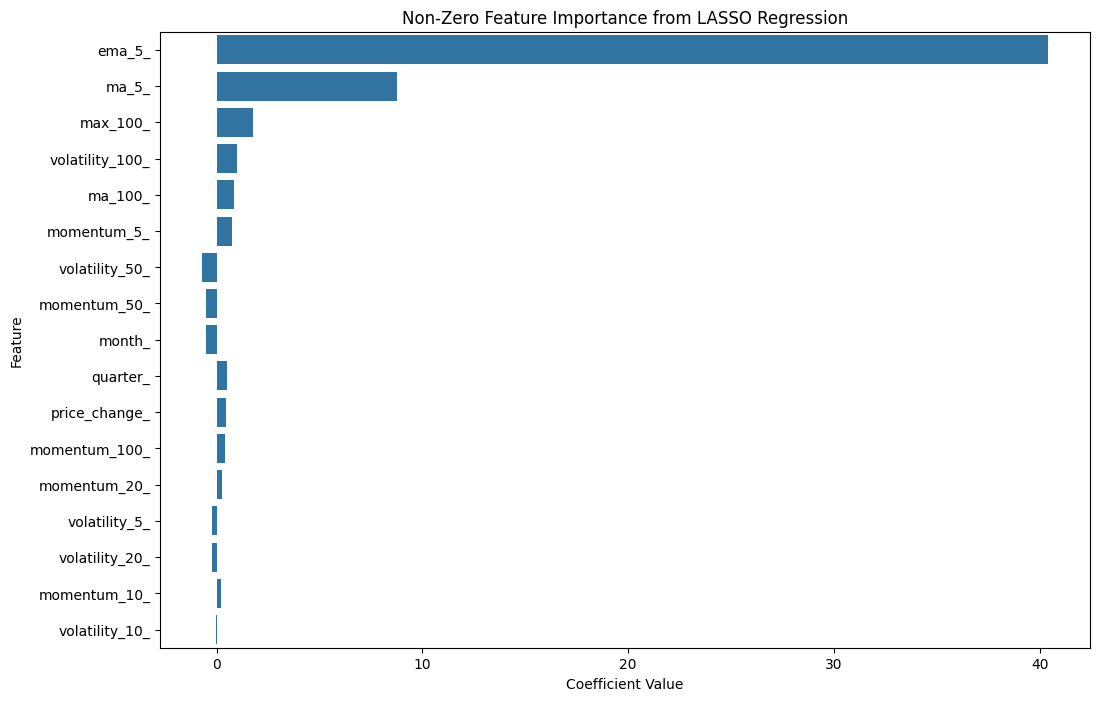

In [ ]:
# Get feature importance - LASSO is great for feature selection
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_lasso.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

# Flatten MultiIndex column names to strings
feature_importance['Feature'] = feature_importance['Feature'].apply(lambda x: '_'.join(x) if isinstance(x, tuple) else x)


# Filter out zero coefficients (features LASSO eliminated)
non_zero_features = feature_importance[feature_importance['Coefficient'] != 0]

print(f"Number of features used: {len(non_zero_features)} out of {len(feature_importance)}")

# Plot non-zero features
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=non_zero_features)
plt.title('Non-Zero Feature Importance from LASSO Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

Model Diagnostics

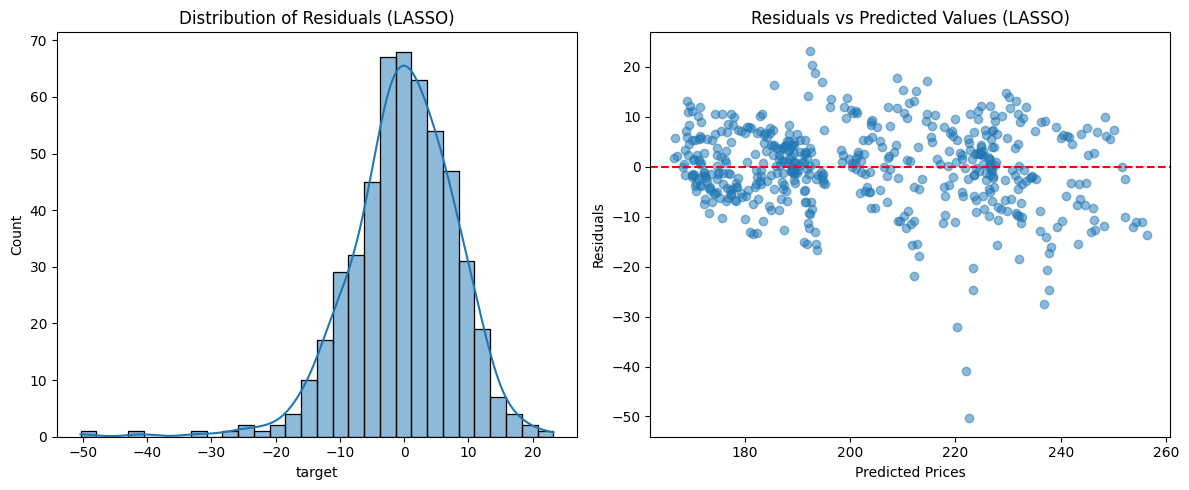

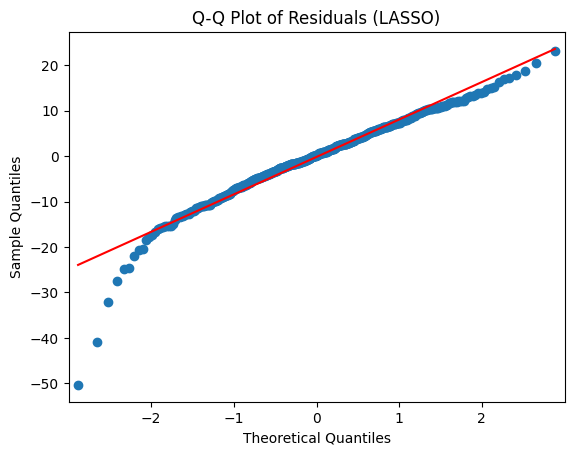

In [ ]:
# Residual analysis
residuals = y_test - y_test_pred

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals (LASSO)')

plt.subplot(1, 2, 2)
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values (LASSO)')    # I need some rice!!!... and I need to play apex!!
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

# Q-Q plot
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals (LASSO)')
plt.show()